I have already done considerable experimentation and preprocessing with machine learning models for classfying gender based on essay text.  The best models so far are coming from tfidf vectorization on stemmed essay text with single words only.

I now try various models and params on the vectorizer to get the highest ROC_AUC score possible.  I will then tune model for accuracy.

In [44]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import interp
from bs4 import BeautifulSoup
import re

In [3]:
df = pd.read_csv('../../Assets/A/stemmed_essays.csv', index_col='Unnamed: 0')

In [4]:
df.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,orientation,pets,religion,sex,sign,smokes,speaks,status,essays,stemmed_essays
0,28,curvy,mostly vegetarian,socially,sometimes,working on space camp,here atm just looking for chill friends i am...,clown school,making people laugh playing with kids and do...,my boyish charm,...,straight,likes dogs and likes cats,atheism,f,sagittarius and it&rsquo;s fun to think about,no,english,seeing someone,here atm just looking for chill friends i am...,here atm just look for chill friend i am aweso...
1,31,fit,NaN,socially,sometimes,graduated from college/university,i imagine that yes is the only living thing ...,studying and practicing massage bodywork energ...,putting words to feelings cooking procrastin...,um eye contact i m alternately a little rese...,...,straight,likes dogs,buddhism and laughing about it,f,scorpio,NaN,"english, spanish",seeing someone,i imagine that yes is the only living thing ...,i imagin that ye is the onli live thing e e cu...
2,24,fit,strictly anything,socially,never,graduated from college/university,my name is paige i am smart have a great sen...,full time environmental consultant in the east...,being coordinated attracting others to the da...,long and lean healthy quiet at first but no...,...,straight,likes dogs and likes cats,agnosticism and laughing about it,f,sagittarius and it&rsquo;s fun to think about,no,"english (fluently), spanish (poorly)",single,my name is paige i am smart have a great sen...,my name is paig i am smart have a great sens o...
3,35,athletic,strictly anything,socially,never,NaN,i am originally from cincinnati a mid western...,i own my own business and do freelance graphic...,being a good friend making people laugh maki...,you tell me,...,straight,NaN,NaN,f,sagittarius,NaN,"english, spanish, french",single,i am originally from cincinnati a mid western...,i am origin from cincinnati a mid western girl...
4,35,average,NaN,socially,never,graduated from masters program,a spirited compassionate woman who is as comf...,i ve lived in san francisco for over ten years...,laughing at people s jokes showing compassion...,that i m a shorty,...,straight,NaN,NaN,f,scorpio,no,english,single,a spirited compassionate woman who is as comf...,a spirit compassion woman who is as comfort pr...


In [3]:
df.shape

(53951, 32)

In [6]:
df.stemmed_essays = df.stemmed_essays.replace(np.nan, '')

In [7]:
def sex_encoder(x):
    if x == 'm':
        return 1
    else:
        return 0

X = df.stemmed_essays
y = df.sex.apply(sex_encoder)

### Multinomial Naive Bayes

In [12]:
pipeNB = make_pipeline(TfidfVectorizer(stop_words='english', max_features=2000), MultinomialNB())

In [13]:
cv_nb = cross_val_score(pipeNB, X, y, cv = 5, scoring='roc_auc')

In [14]:
cv_nb.mean()

0.82359743556047005

In [43]:
pipeNB = make_pipeline(TfidfVectorizer(stop_words='english', max_features=5000), MultinomialNB())

In [41]:
cv_nb = cross_val_score(pipeNB, X, y, cv = 5, scoring='roc_auc')

In [42]:
cv_nb.mean()

0.84779359321877068

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

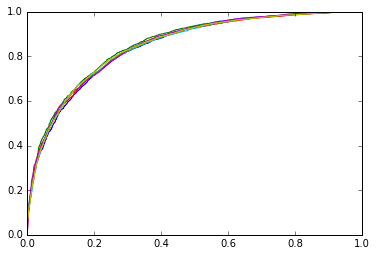

In [38]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y, n_folds=6)
classifier = pipeNB


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

Performance is quite consistent across folds.  Not surprising given size of dataset.

### Try Random Forest

The random forest classifier has performed quite well relative to the MultinomialNB with smaller numbers of features and larger numbers of estimators.  How does it compare to the best Naive Bayes model to date?

In [15]:
pipeRFC = make_pipeline(TfidfVectorizer(stop_words='english', max_features=2000), RandomForestClassifier(n_estimators = 20))

In [16]:
cv_rfc = cross_val_score(pipeRFC, X, y, cv = 5, scoring ='roc_auc')

In [17]:
cv_rfc.mean()

0.75781467370022881

In [18]:
pipeRFC_big = make_pipeline(TfidfVectorizer(stop_words='english', max_features=2000), RandomForestClassifier(n_estimators = 100))

In [19]:
cv_rfc = cross_val_score(pipeRFC_big, X, y, cv = 5, scoring ='roc_auc')

In [20]:
cv_rfc.mean()

0.80971893773084958

In [25]:
pipeRFC_bigger = make_pipeline(TfidfVectorizer(stop_words='english', max_features=2000), RandomForestClassifier(n_estimators = 200))

In [26]:
cv_rfc = cross_val_score(pipeRFC_bigger, X, y, cv = 5, scoring ='roc_auc')

In [27]:
cv_rfc.mean()

0.81940132767344775

Random Forest classifiers outperformed MultinomialNB on some earlier tests but with stemming and larger numbers of features in tfidf vectorizer, MultinomialNB wins.

### Try a support vector machine (just for fun)

In [9]:
from sklearn.svm import LinearSVC, SVC
# SVC with 'rbf' kernel was so slow that I killed it
# I doubt it would outperform linear kernel
from sklearn.linear_model import LogisticRegression

In [48]:
pipeSVC = make_pipeline(TfidfVectorizer(stop_words='english', max_features=5000), LinearSVC())

cv_svc = cross_val_score(pipeSVC, X, y, cv = 5, scoring='roc_auc')
cv_svc.mean()

0.87346092983089141

In [18]:
pipeLR = make_pipeline(TfidfVectorizer(stop_words='english', max_features=5000), LogisticRegression())

cv_lr = cross_val_score(pipeSVC, X, y, cv = 5, scoring='roc_auc')
cv_lr.mean()

0.88060032134746624

Wow!  Parametric models really start to shine as we increase the number of features.  

### Let's try even more features.

In [8]:
pipeSVC = make_pipeline(TfidfVectorizer(stop_words='english', min_df=10), LinearSVC())

cv_svc = cross_val_score(pipeSVC, X, y, cv = 5, scoring='roc_auc')
cv_svc.mean()

0.87990733607770955

In [9]:
pipeNB = make_pipeline(TfidfVectorizer(stop_words='english', min_df=10), MultinomialNB())

cv_NB = cross_val_score(pipeNB, X, y, cv = 5, scoring='roc_auc')
cv_NB.mean()

0.85798846537132611

Wow!  Things are improving.  Keep lowering min_df.

In [16]:
pipeSVC = make_pipeline(TfidfVectorizer(stop_words='english', min_df=5), LinearSVC())

cv_svc = cross_val_score(pipeSVC, X, y, cv = 5, scoring='roc_auc')
cv_svc.mean()

0.88060033922126169

In [11]:
pipeNB = make_pipeline(TfidfVectorizer(stop_words='english', min_df=5), MultinomialNB())

cv_NB = cross_val_score(pipeNB, X, y, cv = 5, scoring='roc_auc')
cv_NB.mean()

0.85636551537173733

In [12]:
pipeSVC = make_pipeline(TfidfVectorizer(stop_words='english', min_df=3), LinearSVC())

cv_svc = cross_val_score(pipeSVC, X, y, cv = 5, scoring='roc_auc')
cv_svc.mean()

0.8808290664340781

In [13]:
pipeNB = make_pipeline(TfidfVectorizer(stop_words='english', min_df=3), MultinomialNB())

cv_NB = cross_val_score(pipeNB, X, y, cv = 5, scoring='roc_auc')
cv_NB.mean()

0.85346222305234698

In [19]:
pipeLR = make_pipeline(TfidfVectorizer(stop_words='english', min_df=3), LogisticRegression())

cv_lr = cross_val_score(pipeSVC, X, y, cv = 5, scoring='roc_auc')
cv_lr.mean()

0.88060033565560225

In [31]:
# Logistic Regression and linearSVC are still neck and neck.
# Grid search optimal params

# Gridsearch optimal SVC

param_grid = dict(svc__C=[.1,.5,1,1.5,2,3,5])
vec = TfidfVectorizer(stop_words='english', min_df=3)

svc = LinearSVC()

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.883816072297


In [32]:
print cv.best_params_

{'svc__C': 0.5}


In [15]:
# Logistic Regression and linearSVC are still neck and neck.
# Grid search optimal params

# Gridsearch optimal logistic regression

param_grid = dict(lr__C=[.1,.5,1,1.5,2,3,5,10], lr__penalty=['l1','l2'])
vec = TfidfVectorizer(stop_words='english', min_df=3)

lr = LogisticRegression()

pipe = Pipeline(steps=[('vec', vec), ('lr', lr)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.886074262305


In [30]:
print cv.best_params_

{'lr__penalty': 'l2', 'lr__C': 3}


Logistic Regression is winning!

### Revisit ngram range

In [16]:
# Gridsearch optimal ngram range for logistic regression

param_grid = dict(vec__ngram_range=[(1,i) for i in range(1,5)])
vec = TfidfVectorizer(stop_words='english', min_df=3)

lr = LogisticRegression(C = 3)

pipe = Pipeline(steps=[('vec', vec), ('lr', lr)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.89369795466


In [19]:
print cv.best_params_

{'vec__ngram_range': (1, 2)}


In [21]:
best_model = cv.best_estimator_

In [24]:
## Try MultinomialNB and SVC with ngram_range(1,2)

pipeNB = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=3), MultinomialNB())

cv_NB = cross_val_score(pipeNB, X, y, cv = 5, scoring='roc_auc')
cv_NB.mean()

0.80060904349846784

In [28]:
# Grid search c for SVC
# Can expect it not to change too drastically from best estimator before(c=.5)

# Logistic Regression and linearSVC are still neck and neck.
# Grid search optimal params

# Gridsearch optimal SVC

param_grid = dict(svc__C=[.3,.5,.7])
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=3)

svc = LinearSVC()

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.895795983485


In [29]:
print cv.best_params_

{'svc__C': 0.5}


In [26]:
# Gridsearch C for logistic regression

param_grid = dict(lr__C=[2, 2.5,3,3.5,4])
vec = TfidfVectorizer(stop_words='english', min_df=3)

lr = LogisticRegression(penalty='l2')

pipe = Pipeline(steps=[('vec', vec), ('lr', lr)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.886146779616


In [27]:
print cv.best_params_

{'lr__C': 2.5}


Now SVM is outperforming logistic regression!  Grid search best ngram range for SVM.

In [31]:
# Gridsearch optimal ngram range for SVM with c=.5 (best estimator to date)

param_grid = dict(vec__ngram_range=[(1,i) for i in range(1,5)])
vec = TfidfVectorizer(stop_words='english', min_df=3)

svc = LinearSVC(C=.5)

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'roc_auc')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.895796007075


In [32]:
print cv.best_params_

{'vec__ngram_range': (1, 2)}


In [33]:
best_model = cv.best_estimator_

## Take best model by AUC score and tune for accuracy

In [51]:
param_grid = dict(svc__class_weight=[{0:.4, 1:.6},{0:.5, 1:.5},{0:.6, 1:.4},'balanced'])

vec = TfidfVectorizer(stop_words='english', min_df=3, ngram_range=(1,2))

svc = LinearSVC(C=.5)

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'accuracy')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.819688235621


In [53]:
cv.best_params_

{'svc__class_weight': {0: 0.5, 1: 0.5}}

In [54]:
param_grid = dict(svc__class_weight=[{0:.45, 1:.55},{0:.5, 1:.5},{0:.55, 1:.45}])

vec = TfidfVectorizer(stop_words='english', min_df=3, ngram_range=(1,2))

svc = LinearSVC(C=.5)

pipe = Pipeline(steps=[('vec', vec), ('svc', svc)])

cv = GridSearchCV(pipe, param_grid, scoring = 'accuracy')

cv.fit(X, y)

print cv.best_estimator_
print cv.best_score_

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.819688235621


In [55]:
cv.best_params_

{'svc__class_weight': {0: 0.5, 1: 0.5}}

In [59]:
best_model = cv.best_estimator_

In [61]:
best_model

Pipeline(steps=[('vec', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

## Test best model for final score

In [36]:
test = pd.read_csv('../../Assets/A/test.csv')

In [37]:
test.head()

,Unnamed: 0,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,52767,28,curvy,mostly vegetarian,socially,sometimes,working on space camp,here atm just looking for chill friends.<br />...,clown school.,-making people laugh<br />\n-playing with kids...,...,"san francisco, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,atheism,f,sagittarius and it&rsquo;s fun to think about,no,english,seeing someone
1,33059,31,fit,NaN,socially,sometimes,graduated from college/university,"""i imagine that yes is the only living thing.""...",studying and practicing massage/bodywork/energ...,"putting words to feelings, cooking, procrastin...",...,"oakland, california",NaN,straight,likes dogs,buddhism and laughing about it,f,scorpio,NaN,"english, spanish",seeing someone
2,30123,24,fit,strictly anything,socially,never,graduated from college/university,"my name is paige. i am smart, have a great sen...",full-time environmental consultant in the east...,"being coordinated, attracting others to the da...",...,"berkeley, california",doesn&rsquo;t have kids,straight,likes dogs and likes cats,agnosticism and laughing about it,f,sagittarius and it&rsquo;s fun to think about,no,"english (fluently), spanish (poorly)",single
3,43140,35,athletic,strictly anything,socially,never,NaN,"i am originally from cincinnati, a mid-western...",i own my own business and do freelance graphic...,being a good friend.<br />\nmaking people laug...,...,"oakland, california",NaN,straight,NaN,NaN,f,sagittarius,NaN,"english, spanish, french",single
4,11312,35,average,NaN,socially,never,graduated from masters program,"a spirited, compassionate woman who is as comf...",i've lived in san francisco for over ten years...,"laughing at people's jokes, showing compassion...",...,"san francisco, california",NaN,straight,NaN,NaN,f,scorpio,no,english,single


In [45]:
# Consolidate essays into one essay

# Create list of all columns that are essays
essay_list = [('essay%i') %i for i in range(10)]
# Replace empty essays with ' '

test.ix[:,essay_list] = test.ix[:,essay_list].replace(np.nan,'', regex=True)

def essay_to_words( raw_essay ):
    
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    text = BeautifulSoup(raw_essay, 'lxml').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z0-9 ]", " ", text) 
    #
    # 3. Convert to lower case
    words = letters_only.lower()                            

    return words

# Write new column to df that contains all essays
test['essays'] = (test.essay0 + ' ' + test.essay1 + ' ' + test.essay2 + ' ' + test.essay3 + ' ' + test.essay4 + ' ' 
              + test.essay5 + ' ' + test.essay6 + ' ' + test.essay7 + ' ' + test.essay8 + ' ' + test.essay9)
test['essays'] = test.essays.apply(essay_to_words)
# stem essay
from nltk.stem.porter import *
stemmer = PorterStemmer()

def stem(essay):
    stems = [stemmer.stem(word) for word in essay.lower().split()]
    return ' '.join(stems)

test['stemmed_essays'] = test['essays'].apply(stem)

# feed through pipeline and predict

X_test = test.stemmed_essays
y_test = test.sex.apply(sex_encoder)

In [62]:
y_pred = best_model.predict(X_test)

In [63]:
print metrics.accuracy_score(y_test, y_pred)

0.949639487683


WOO HOO!!!  I can predict gender of the writer from essay text with 95% accuracy!